Previously we used a three layer neural net to identify low resolution images ($8\times$8) of handwritten numbers. Here we'll consider higher resolution images ($28\times 28$) of the same and add convolutional structure to help the neural net learn the correct labels for them. First we load the data and perform the usual transformations to prepare it for the input layer.

In [36]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from keras.datasets import mnist

# normalize the data, hot-one encode the target data; create
# training and test sets
(Xtrain, ytrain), (Xtest, ytest) = mnist.load_data()
Xtrain = Xtrain[0:20000]
ytrain = ytrain[0:20000]
y_pre_train = ytrain
y_pre_test  = ytest
ytrain = np.zeros((y_pre_train.shape[0],10))
ytest  = np.zeros((y_pre_test.shape[0],10))
for i in range(y_pre_train.shape[0]):
    ytrain[i,y_pre_train[i]]=1.0
for i in range(y_pre_test.shape[0]):
    ytest[i,y_pre_test[i]]=1.0
Xtrain = (Xtrain-Xtrain.mean())/Xtrain.var()
Xtest  = (Xtest-Xtest.mean())/Xtest.var()

Next we define a routine that will capture mini-frames of the input image, which will later be transformed into numbers via the convolution kernels.

In [2]:
# moving window of size frame_rows x frame_cols moves over
# every position in the image, such that the frame does not
# move outside the image, and captures part of the image
# for each of those positions
def capture_frames(image,frame_rows,frame_cols):
    image_rows = image.shape[0]
    image_cols = image.shape[1]
    frame_pos_horz = image_cols-frame_cols+1
    frame_pos_vert = image_rows-frame_rows+1
    captured_frames = np.zeros((frame_pos_horz*frame_pos_vert, \
                               frame_rows,frame_cols))
    for i in range(frame_pos_horz):
        for j in range(frame_pos_vert):
            single_frame = image[i:i+frame_rows,j:j+frame_cols]
            captured_frames[frame_pos_vert*i+j,:,:]=single_frame
    return captured_frames.reshape(frame_pos_horz*frame_pos_vert, \
                                   frame_rows*frame_cols).T

As usual, we'll also need to define the activation functions along with there derivatives.

In [3]:
# define the activation functions and their derivatives
# layer_num = 1 will return the function for layer 1 and
# layer_num = 2 will return that for layer 2
def activ_func(x,layer_num):
    if (layer_num==1):
        return np.tanh(x)
    elif (layer_num==2):
        return np.exp(x)/np.exp(x).sum()

def activ_deriv(x,layer_num):
    if (layer_num==1):
        return 1.0-np.tanh(x)**2.0
    elif (layer_num==2):
        soft_max = np.exp(x)/np.exp(x).sum()
        return soft_max*(1.0-soft_max)

def dirac_delta(x,y):
    return (x==y).astype('int64')

Now we'll initialize the kernels and the weights for the fully connected parts of the network.

In [4]:
frame_rows = 8
frame_cols = 8
num_kernels= 9
image_rows = Xtrain[0].shape[0]
image_cols = Xtrain[0].shape[1]
frame_pos_horz = image_cols-frame_cols+1
frame_pos_vert = image_rows-frame_rows+1
# N.B.: if the weights are initialized lying too close together,
# gradient descent will not find many distinct kernels!
kernels = 2.0*np.random.random((num_kernels, \
                               frame_rows*frame_cols))-1.0
grad_kernel = np.zeros((num_kernels,frame_rows*frame_cols))

# set the number of neurons in each fully connected layer and 
# initialize the weights
num_input  = frame_pos_horz*frame_pos_vert
num_hidden = int(num_input/2.0)
num_hidden = 100
num_output = 10
weights_01 = 2.0*np.random.random((num_input,num_hidden))-1.0
weights_12 = 2.0*np.random.random((num_hidden,num_output))-1.0

Now for the big part: to iterate over the images and train the neural net!

In [5]:
alpha = 0.01
max_iter = 50
err_tol  = 0.1
err = 1000.0
iter = 0
# toggle dropout on or off
dropout = 0
while ((iter<max_iter) & (err>err_tol)):
    err = 0.0
    for n in range(Xtrain.shape[0]):
        # forward propagation convolution + pooling steps
        image = Xtrain[n]
        image_frames = capture_frames(image, \
                                      frame_rows,frame_cols)

        # form layer_0 pre-pooling step
        layer_0_pre = np.zeros((num_kernels,image_frames.shape[1]))
        for k in range(num_kernels):
            layer_0_pre[k,:]= \
                np.matmul(kernels[k].reshape(1,len(kernels[k])), \
                          image_frames)
        which_kernel = np.argmax(layer_0_pre,axis=0)

        # pooling step
        layer_0 = \
            np.max(layer_0_pre,axis=0).reshape(1,layer_0_pre.shape[1])
        layer_0 = activ_func(layer_0,1)
        # forward propagation to the other layers
        layer_1 = activ_func(np.matmul(layer_0,weights_01),1)
        if (dropout == 1):
            dropout_mask = \
                np.random.randint(0,2,layer_1.shape)
            layer_1 *= 2.0*dropout_mask
        layer_2 = activ_func(np.matmul(layer_1,weights_12),2)

        # backprop step for the fully connected neurons
        delta = layer_2-ytrain[n]
        deriv_vec2   = activ_deriv(layer_2,2)
        deriv_diag2  = np.diag(deriv_vec2.ravel())
        gradient_12  = \
                np.outer(layer_1,np.matmul(delta,deriv_diag2))
        deriv_vec1   = activ_deriv(layer_1,1)
        deriv_diag1  = np.diag(deriv_vec1.ravel())
        if (dropout==1):
            dropout_diag = np.diag(dropout_mask.ravel())
            deriv_diag1 *= dropout_diag
        omega = np.matmul(weights_12.T,deriv_diag1)
        omega = np.matmul(deriv_diag2,omega)
        delta_omega = np.matmul(delta,omega)
        gradient_01 = np.outer(layer_0,delta_omega)

        weights_12 -= alpha*gradient_12
        weights_01 -= alpha*gradient_01

        # backprop step for the kernel corrections
        grad_kernel_indices = \
            np.indices((grad_kernel.shape[0],grad_kernel.shape[1]))
        for k in range(num_kernels):
            mask = (which_kernel==k).astype('int64')
            image_frames_masked = image_frames*mask
            deriv_vec0   = activ_deriv(layer_0,1)
            deriv_diag0  = np.diag(deriv_vec0.ravel())
            intermed_0 = np.matmul(deriv_diag0,image_frames_masked.T)
            intermed_1 = np.matmul(weights_01.T,intermed_0)
            intermed_2 = np.matmul(deriv_diag1,intermed_1)
            intermed_3 = np.matmul(weights_12.T,intermed_2)
            intermed_4 = np.matmul(deriv_diag2,intermed_3)
            grad_kernel[k] = np.matmul(delta,intermed_4)
        kernels -= alpha*grad_kernel

        err += np.sum(delta**2.0)
    err /= Xtrain.shape[0]
    print(iter,err)
    iter += 1

if (iter<max_iter):
    print("converged at iteration: ",iter-1)
    print("average error: ",err)
else:
    print("failed to converge")

0 0.5708498546098345
1 0.238968805822179
2 0.18376262704300791
3 0.15884420078434203
4 0.14349670143331575
5 0.13303330132005825
6 0.12524633753039854
7 0.1190555095240238
8 0.11391619250773542
9 0.1094220182872265
10 0.10543376418131505
11 0.10185387081060268
12 0.09860016478135072
converged at iteration:  12
average error:  0.09860016478135072


Now let's check the out-of-sample error.

In [6]:
err = 0.0
num_correct = 0
for n in range(Xtest.shape[0]):
    # forward propagation convolution + pooling steps
    image = Xtest[n].reshape(image_rows,image_cols)
    image_frames = capture_frames(image, \
                                  frame_rows,frame_cols)

    # form layer_0 pre-pooling step
    layer_0_pre = np.zeros((num_kernels,image_frames.shape[1]))
    for k in range(num_kernels):
        layer_0_pre[k,:]= \
            np.matmul(kernels[k].reshape(1,len(kernels[k])), \
                      image_frames)
    which_kernel = np.argmax(layer_0_pre,axis=0)

    # pooling step
    layer_0 = \
        np.max(layer_0_pre,axis=0).reshape(1,layer_0_pre.shape[1])

    # forward propagation to the other layers
    layer_1 = activ_func(np.matmul(layer_0,weights_01),1)
    layer_2 = activ_func(np.matmul(layer_1,weights_12),2)

    delta = layer_2.ravel()-ytest[n]
    err += np.sum(delta**2.0)
    if (layer_2.ravel().round()==ytest[n]).all():
        num_correct += 1
err /= Xtest.shape[0]
print("average test set error:",err)
frac_correct = num_correct/Xtest.shape[0]
print("percent correct:",frac_correct*100.0)

average test set error: 0.10490452221860885
percent correct: 92.57


Since we got pretty decent results, let's save the kernels and weights in output files in case we want to use them again later.

In [7]:
# save the kernels and weights in csv format
import pandas as pd
kernels = pd.DataFrame(kernels)
weights_01 = pd.DataFrame(weights_01)
weights_12 = pd.DataFrame(weights_12)
kernels.to_csv('kernels.csv',index=False)
weights_01.to_csv('weights_01.csv',index=False)
weights_12.to_csv('weights_12.csv',index=False)

Let's have a look at the kernels that our convolutional net found.

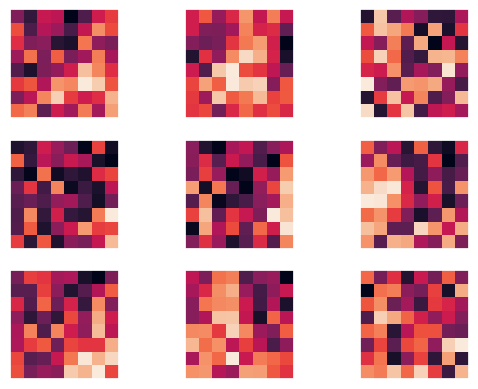

In [14]:
def show_kernels(num_kernels,frame_rows,frame_cols):
    kernels = pd.read_csv('kernels.csv').to_numpy()
    kernels = kernels.reshape(num_kernels,frame_rows,frame_cols)

    num_plot_rows = round(num_kernels/3.0)
    num_plot_cols = 3
    fig, axes = plt.subplots(num_plot_rows,num_plot_cols)
    for i, ax in enumerate(axes.flat):
        if (i<num_kernels):
            ax.imshow(kernels[i])
            ax.xaxis.set_tick_params(labelbottom=False)
            ax.yaxis.set_tick_params(labelleft=False)
            ax.grid(None)
    plt.show()
    
show_kernels(num_kernels,frame_rows,frame_cols)

We can also see what an image filtered by each of these kernels looks like.

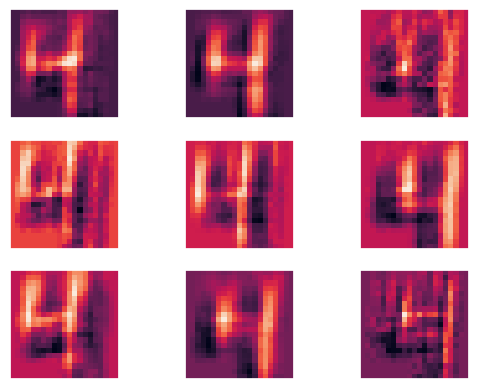

In [35]:
image = Xtrain[92]
kernels = pd.read_csv('kernels.csv').to_numpy()
num_kernels = kernels.shape[0]

image_frames = capture_frames(image,frame_rows,frame_cols)

layer_0_pre = np.zeros((num_kernels,image_frames.shape[1]))
for k in range(num_kernels):
    layer_0_pre[k,:]= \
        np.matmul(kernels[k].reshape(1,len(kernels[k])), \
                  image_frames)

filtered_rows = image_rows-frame_rows+1
filtered_cols = image_cols-frame_cols+1
filtered_img = layer_0_pre.reshape(num_kernels,filtered_rows, \
                                               filtered_cols)

num_plot_rows = round(num_kernels/6.0)+1
num_plot_cols = num_plot_rows
fig, axes = plt.subplots(num_plot_rows,num_plot_cols)
for i, ax in enumerate(axes.flat):
    ax.imshow(filtered_img[i])
    ax.xaxis.set_tick_params(labelbottom=False)
    ax.yaxis.set_tick_params(labelleft=False)
    ax.grid(None)
plt.show()